In [ ]:
!pip install xgboost imbalanced-learn shap -q

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import ADASYN, RandomOverSampler
from xgboost import XGBClassifier

import shap
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
np.random.seed(SEED)


In [ ]:
train = pd.read_csv("telco_churn_train.csv")
val   = pd.read_csv("telco_churn_validation.csv")
test  = pd.read_csv("telco_churn_test.csv")

train["split"] = "train"
val["split"]   = "val"
test["split"]  = "test"

df_all = pd.concat([train, val, test], ignore_index=True)
print(df_all.shape)
df_all.head()


(7043, 53)


,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,...,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code,split
0,72,4,19.44,0,NaN,NaN,51,San Mateo,4849,Two Year,...,25,2191.15,0,486.00,0.0,2677.15,0,1,94403,train
1,27,59,45.62,0,NaN,NaN,27,Sutter Creek,3715,Month-to-Month,...,35,3418.20,0,1596.70,0.0,5014.90,1,1,95685,train
2,59,0,16.07,0,NaN,NaN,59,Santa Cruz,5092,Month-to-Month,...,46,851.20,0,739.22,0.0,1590.42,0,0,95064,train
3,25,27,0.00,0,NaN,NaN,49,Brea,2068,One Year,...,27,1246.40,30,0.00,0.0,1276.40,1,0,92823,train
4,31,21,17.22,1,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,...,58,3563.80,0,998.76,0.0,4562.56,0,1,95117,train


In [ ]:
df = df_all.copy()

# Binary target
y_bin = df["Churn"].astype(int)

# Columns that leak target or are directly derived from it
leakage_cols = [
    "Churn",           # target itself
    "Churn Category",
    "Churn Reason",
    "Churn Score",     # prior risk scoring model output
    "Customer Status"  # e.g. 'Churned', 'Joined', 'Stayed'
]

# ID / geo columns that are not useful for generalization
id_like_cols = [
    "Customer ID",
    "Lat Long",
    "Latitude",
    "Longitude",
    "Zip Code"
]

df_features = df.drop(columns=leakage_cols + id_like_cols, errors="ignore")
print("Remaining columns:", len(df_features.columns))
df_features.head()


Remaining columns: 43


,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,City,CLTV,Contract,Country,Dependents,Device Protection Plan,Gender,...,Streaming TV,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,split
0,72,4,19.44,San Mateo,4849,Two Year,United States,0,1,Female,...,0,25,2191.15,0,486.00,0.0,2677.15,0,1,train
1,27,59,45.62,Sutter Creek,3715,Month-to-Month,United States,0,1,Male,...,1,35,3418.20,0,1596.70,0.0,5014.90,1,1,train
2,59,0,16.07,Santa Cruz,5092,Month-to-Month,United States,0,0,Male,...,0,46,851.20,0,739.22,0.0,1590.42,0,0,train
3,25,27,0.00,Brea,2068,One Year,United States,0,1,Male,...,0,27,1246.40,30,0.00,0.0,1276.40,1,0,train
4,31,21,17.22,San Jose,4026,One Year,United States,0,1,Male,...,0,58,3563.80,0,998.76,0.0,4562.56,0,1,train


In [ ]:
df_fe = df_features.copy()

# Example tenure buckets if 'Tenure in Months' exists
if "Tenure in Months" in df_fe.columns:
    bins   = [0, 12, 24, 36, 48, 60, np.inf]
    labels = ["0-12", "13-24", "25-36", "37-48", "49-60", ">60"]
    df_fe["TenureBucket"] = pd.cut(
        df_fe["Tenure in Months"],
        bins=bins, labels=labels, right=False
    )

# Example: Avg monthly from total charges (avoid division by 0)
if "Tenure in Months" in df_fe.columns and "Total Charges" in df_fe.columns:
    t = df_fe["Tenure in Months"].replace(0, np.nan)
    df_fe["AvgMonthlyFromTotal"] = df_fe["Total Charges"] / t

# Example: Revenue-to-monthly ratio
if "Monthly Charge" in df_fe.columns and "Total Revenue" in df_fe.columns:
    df_fe["RevenueToMonthlyRatio"] = (
        df_fe["Total Revenue"] / (df_fe["Monthly Charge"] + 1e-6)
    )

df_fe.head()


,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,City,CLTV,Contract,Country,Dependents,Device Protection Plan,Gender,...,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,split,TenureBucket,AvgMonthlyFromTotal,RevenueToMonthlyRatio
0,72,4,19.44,San Mateo,4849,Two Year,United States,0,1,Female,...,0,486.00,0.0,2677.15,0,1,train,25-36,87.646000,30.284502
1,27,59,45.62,Sutter Creek,3715,Month-to-Month,United States,0,1,Male,...,0,1596.70,0.0,5014.90,1,1,train,25-36,97.662857,52.512041
2,59,0,16.07,Santa Cruz,5092,Month-to-Month,United States,0,0,Male,...,0,739.22,0.0,1590.42,0,0,train,37-48,18.504348,81.143873
3,25,27,0.00,Brea,2068,One Year,United States,0,1,Male,...,30,0.00,0.0,1276.40,1,0,train,25-36,46.162963,27.838604
4,31,21,17.22,San Jose,4026,One Year,United States,0,1,Male,...,0,998.76,0.0,4562.56,0,1,train,49-60,61.444828,75.664344


In [ ]:
df_model = df_fe.copy()

# Identify numeric + categorical
num_cols = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [c for c in df_model.columns if c not in num_cols]

# Fill numeric missing with median
df_model[num_cols] = df_model[num_cols].fillna(df_model[num_cols].median())

# Fill categoricals with 'Unknown' then one-hot
for col in cat_cols:
    df_model[col] = df_model[col].astype("category").cat.add_categories("Unknown")
    df_model[col] = df_model[col].fillna("Unknown")

X_all = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)
print("Encoded shape:", X_all.shape)


Encoded shape: (7043, 1169)


In [ ]:
split = df_all["split"]

X_train = X_all[split == "train"].reset_index(drop=True)
X_val   = X_all[split == "val"].reset_index(drop=True)
X_test  = X_all[split == "test"].reset_index(drop=True)

y_train_bin = y_bin[split == "train"].reset_index(drop=True)
y_val_bin   = y_bin[split == "val"].reset_index(drop=True)
y_test_bin  = y_bin[split == "test"].reset_index(drop=True)

X_train.shape, X_val.shape, X_test.shape


((4225, 1169), (1409, 1169), (1409, 1169))

In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=SEED)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train_bin)

print("Original train class counts:")
print(y_train_bin.value_counts())
print("\nAfter ADASYN:")
print(y_train_bal.value_counts())


Original train class counts:
Churn
0    3104
1    1121
Name: count, dtype: int64

After ADASYN:
Churn
1    3240
0    3104
Name: count, dtype: int64


In [ ]:
xgb_teacher = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=250,
    learning_rate=0.08,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=4,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=SEED,
    n_jobs=-1
)

xgb_teacher.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_val, y_val_bin)],
    verbose=False
)

# Validation evaluation
y_val_pred   = xgb_teacher.predict(X_val)
y_val_proba  = xgb_teacher.predict_proba(X_val)[:, 1]

print("Teacher – Validation metrics")
print("Accuracy :", accuracy_score(y_val_bin, y_val_pred))
print("F1 (churn):", f1_score(y_val_bin, y_val_pred))
print("AUC       :", roc_auc_score(y_val_bin, y_val_proba))
print(classification_report(y_val_bin, y_val_pred, digits=3))


Teacher – Validation metrics
Accuracy : 0.9609652235628106
F1 (churn): 0.9251700680272109
AUC       : 0.9927665400811181
              precision    recall  f1-score   support

           0      0.968     0.980     0.974      1035
           1      0.942     0.909     0.925       374

    accuracy                          0.961      1409
   macro avg      0.955     0.944     0.949      1409
weighted avg      0.961     0.961     0.961      1409



In [ ]:
# Fixed thresholds chosen for business interpretability
LOW_THR  = 0.30
HIGH_THR = 0.70

print("LOW_THR :", LOW_THR)
print("HIGH_THR:", HIGH_THR)

def prob_to_risk(p, low_thr=LOW_THR, high_thr=HIGH_THR):
    if p < low_thr:
        return 0   # Low
    elif p > high_thr:
        return 2   # High
    else:
        return 1   # Medium

y_tv_risk = pd.Series([prob_to_risk(p) for p in p_tv], name="Risk")

print("Risk distribution (train+val):")
print(
    y_tv_risk.value_counts(normalize=True)
             .rename({0:"Low",1:"Med",2:"High"})
)


LOW_THR : 0.3
HIGH_THR: 0.7
Risk distribution (train+val):
Risk
Low     0.719205
High    0.242989
Med     0.037806
Name: proportion, dtype: float64


In [ ]:
from imblearn.over_sampling import ADASYN, RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# Split back into train/val portions
n_train = len(X_train)

X_train_risk = X_tv.iloc[:n_train].copy()
X_val_risk   = X_tv.iloc[n_train:].copy()

y_train_risk = y_tv_risk.iloc[:n_train].copy()
y_val_risk   = y_tv_risk.iloc[n_train:].copy()

# Balance classes (risk labels) using random oversampling
ros = RandomOverSampler(random_state=SEED)
X_train_risk_bal, y_train_risk_bal = ros.fit_resample(X_train_risk, y_train_risk)

print("Risk class distribution after ROS:")
print(y_train_risk_bal.value_counts())

# Optional: class weights for multi-class
classes = np.array([0, 1, 2])
cw = compute_class_weight(class_weight="balanced",
                          classes=classes,
                          y=y_train_risk_bal)
class_weight_dict = {c: w for c, w in zip(classes, cw)}
class_weight_dict



Risk class distribution after ROS:
Risk
0    3047
2    3047
1    3047
Name: count, dtype: int64


{np.int64(0): np.float64(1.0),
 np.int64(1): np.float64(1.0),
 np.int64(2): np.float64(1.0)}

In [ ]:
xgb_risk = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=250,
    learning_rate=0.08,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=4,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=SEED,
    n_jobs=-1
)

# Convert labels to weights
sample_weights = y_train_risk_bal.map(class_weight_dict).values

xgb_risk.fit(
    X_train_risk_bal,
    y_train_risk_bal,
    sample_weight=sample_weights,
    eval_set=[(X_val_risk, y_val_risk)],
    verbose=True
)


[0]	validation_0-mlogloss:1.01370
[1]	validation_0-mlogloss:0.93750
[2]	validation_0-mlogloss:0.88974
[3]	validation_0-mlogloss:0.85013
[4]	validation_0-mlogloss:0.79724
[5]	validation_0-mlogloss:0.75212
[6]	validation_0-mlogloss:0.71274
[7]	validation_0-mlogloss:0.68262
[8]	validation_0-mlogloss:0.65679
[9]	validation_0-mlogloss:0.63494
[10]	validation_0-mlogloss:0.60782
[11]	validation_0-mlogloss:0.59181
[12]	validation_0-mlogloss:0.57080
[13]	validation_0-mlogloss:0.54546
[14]	validation_0-mlogloss:0.52815
[15]	validation_0-mlogloss:0.51307
[16]	validation_0-mlogloss:0.49767
[17]	validation_0-mlogloss:0.48194
[18]	validation_0-mlogloss:0.46878
[19]	validation_0-mlogloss:0.45135
[20]	validation_0-mlogloss:0.43511
[21]	validation_0-mlogloss:0.42330
[22]	validation_0-mlogloss:0.40903
[23]	validation_0-mlogloss:0.39866
[24]	validation_0-mlogloss:0.38601
[25]	validation_0-mlogloss:0.37752
[26]	validation_0-mlogloss:0.36882
[27]	validation_0-mlogloss:0.35934
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1, num_class=3, ...)

In [ ]:
y_val_risk_pred = xgb_risk.predict(X_val_risk)

print("Validation classification report:")
print(classification_report(
    y_val_risk,
    y_val_risk_pred,
    target_names=["Low", "Medium", "High"],
    digits=3
))


Validation classification report:
              precision    recall  f1-score   support

         Low      0.980     0.968     0.974      1005
      Medium      0.443     0.486     0.464        72
        High      0.947     0.961     0.954       332

    accuracy                          0.942      1409
   macro avg      0.790     0.805     0.797      1409
weighted avg      0.945     0.942     0.943      1409



In [ ]:
p_test = xgb_teacher.predict_proba(X_test)[:, 1]
y_test_risk_true = pd.Series(
    [prob_to_risk(p) for p in p_test],
    name="Risk_true"
)

y_test_risk_pred = xgb_risk.predict(X_test)

print("Test classification report:")
print(classification_report(
    y_test_risk_true,
    y_test_risk_pred,
    target_names=["Low", "Medium", "High"],
    digits=3
))


Test classification report:
              precision    recall  f1-score   support

         Low      0.996     0.972     0.984      1023
      Medium      0.444     0.720     0.550        50
        High      0.967     0.949     0.958       336

    accuracy                          0.957      1409
   macro avg      0.802     0.880     0.830      1409
weighted avg      0.969     0.957     0.962      1409



In [ ]:
medium_idx = (y_test_risk_true == 1)

print("Medium-only test performance:")
print(classification_report(
    y_test_risk_true[medium_idx],
    y_test_risk_pred[medium_idx],
    target_names=["Low", "Medium", "High"],
    digits=3
))


Medium-only test performance:
              precision    recall  f1-score   support

         Low      0.000     0.000     0.000         0
      Medium      1.000     0.720     0.837        50
        High      0.000     0.000     0.000         0

    accuracy                          0.720        50
   macro avg      0.333     0.240     0.279        50
weighted avg      1.000     0.720     0.837        50



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


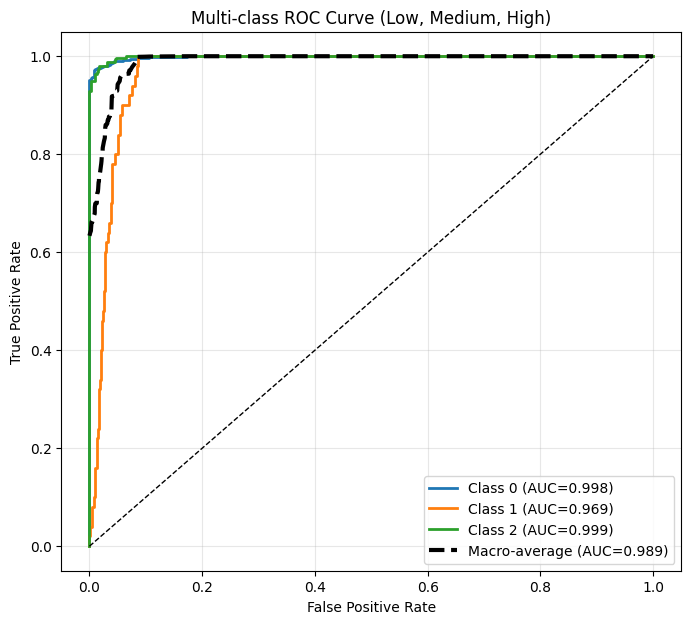

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Prepare labels
classes = [0, 1, 2]  # Low, Medium, High
y_test_risk_oh = label_binarize(y_test_risk_true, classes=classes) # Renamed to avoid conflict

# Predict probabilities
probs = xgb_risk.predict_proba(X_test)

plt.figure(figsize=(8,7))

for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_risk_oh[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"Class {c} (AUC={roc_auc:.3f})")

# macro-average ROC
fpr_macro = dict()
tpr_macro = dict()
all_fpr = np.unique(np.concatenate([roc_curve(y_test_risk_oh[:, i], probs[:, i])[0] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    fpr_i, tpr_i, _ = roc_curve(y_test_risk_oh[:, i], probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)

mean_tpr /= 3
macro_auc = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, linestyle="--", color="black",
         label=f"Macro-average (AUC={macro_auc:.3f})", lw=3)

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (Low, Medium, High)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
xgb_teacher.fit(
    X_train, y_train_bin,
    eval_set=[(X_train, y_train_bin), (X_val, y_val_bin)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1,
              num_parallel_tree=None, ...)

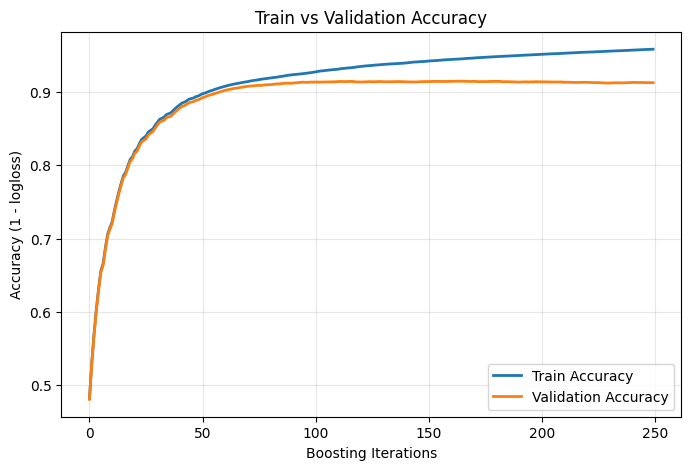

In [ ]:
results = xgb_teacher.evals_result()

train_acc = 1 - np.array(results['validation_0']['logloss'])
val_acc   = 1 - np.array(results['validation_1']['logloss'])

plt.figure(figsize=(8,5))
plt.plot(train_acc, label="Train Accuracy", linewidth=2)
plt.plot(val_acc, label="Validation Accuracy", linewidth=2)

plt.title("Train vs Validation Accuracy")
plt.xlabel("Boosting Iterations")
plt.ylabel("Accuracy (1 - logloss)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

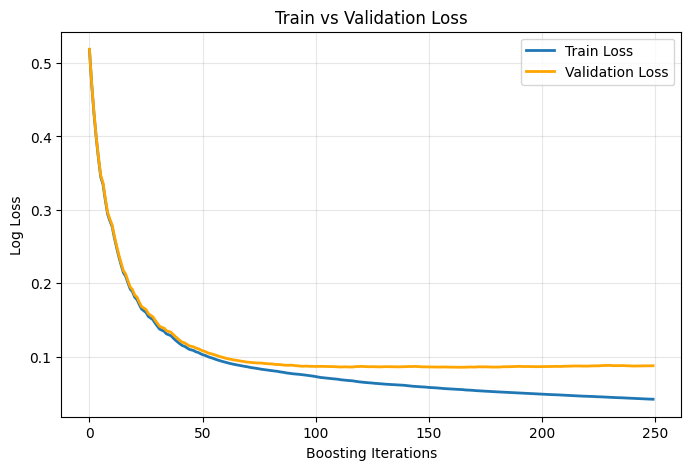

In [ ]:
train_loss = np.array(results['validation_0']['logloss'])
val_loss   = np.array(results['validation_1']['logloss'])

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2, color="orange")

plt.title("Train vs Validation Loss")
plt.xlabel("Boosting Iterations")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

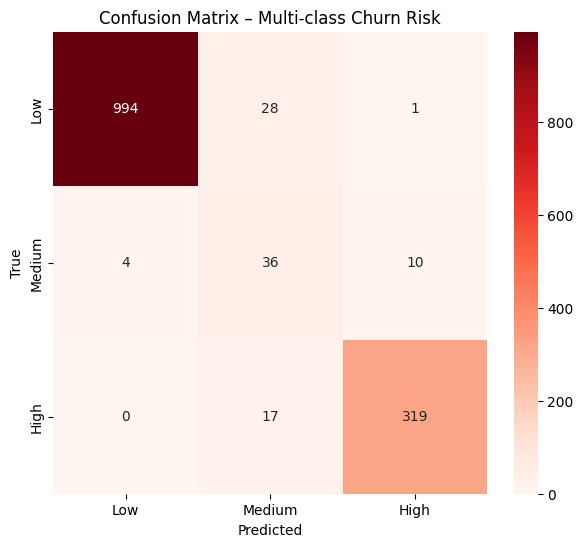

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# True and predicted labels
y_true = y_test_risk_true
y_pred = y_test_risk_pred

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Multi-class Churn Risk")
plt.show()


In [ ]:
# A) build raw profile exactly like the demo
raw = build_profile_row(
    age=38,
    tenure=15,
    monthly_charge=68,
    total_charges=980,
    satisfaction=3,
    fiber_optic="Yes",
    referrals=1,
    avg_long_dist=10
)

print("RAW PROFILE:")
display(raw)

# B) apply same preprocessing as training
X_new, fe_row = preprocess_like_training(raw)
print("Shape after preprocessing:", X_new.shape)

# C) direct predictions from the models
p = xgb_teacher.predict_proba(X_new)[0, 1]
risk = int(xgb_risk.predict(X_new)[0])

print(f"Churn probability = {p:.4f}")
print(f"Risk class (0=Low,1=Med,2=High) = {risk}")
print("Risk bucket thresholds:", LOW_THR, HIGH_THR)


RAW PROFILE:


,Age,Tenure in Months,Monthly Charge,Total Charges,Customer Satisfaction Score,Fiber Optic,Referrals,Avg Monthly Long Distance,Contract,Internet Service,Internet Type,Unlimited Data,Payment Method,Total Revenue,City,Country
0,38,15,68,980,3,Yes,1,10,Month-to-Month,Yes,Fiber optic,1,Credit card,1020,San Jose,United States


Shape after preprocessing: (1, 1169)
Churn probability = 0.9956
Risk class (0=Low,1=Med,2=High) = 2
Risk bucket thresholds: 0.3 0.7


In [ ]:
import joblib

# اگر اسم متغیرهایت فرق دارد، همین جا عوض کن
artifacts = {
    "xgb_teacher": xgb_teacher,                # مدل دودویی برای احتمال چرن
    "xgb_risk": xgb_risk,                      # مدل سه‌کلاسه برای Low/Med/High
    "feature_names": X_train.columns.tolist()  # لیست فیچرها بعد از encoding
}

joblib.dump(artifacts, "telco_churn_models.pkl")

print("Saved to telco_churn_models.pkl")


Saved to telco_churn_models.pkl


In [ ]:
import joblib

loaded = joblib.load("telco_churn_models.pkl")

xgb_teacher = loaded["xgb_teacher"]
xgb_risk = loaded["xgb_risk"]
feature_names = loaded["feature_names"]

print("Models loaded.")
print("Number of features:", len(feature_names))


Models loaded.
Number of features: 1169


In [ ]:
df_test = df_all[split == "test"].reset_index(drop=True)


In [ ]:
risk_map = {0: "Low", 1: "Medium", 2: "High"}

def simple_test(idx):
    idx = int(idx)

    raw = df_test.iloc[[idx]].copy()   # سطر واقعی از تست‌ست

    # همان پردازشی که برای train استفاده کرده‌ای
    X_row, _ = preprocess_like_training(raw)

    # مطمئن شو ستون‌ها با feature_names هم‌خوان هستند
    X_row = X_row.reindex(columns=feature_names, fill_value=0)

    # احتمال چرن از مدل دودویی
    p_churn = float(xgb_teacher.predict_proba(X_row)[0, 1])

    # کلاس ریسک از مدل سه‌کلاسه
    risk_label = int(xgb_risk.predict(X_row)[0])
    risk_text  = risk_map[risk_label]

    print(f"Index: {idx}")
    print(f"Churn probability: {p_churn:.3f}")
    print(f"Risk class: {risk_label} ({risk_text})")
    print()
    print("Main profile columns:")
    cols_show = [
        "Age",
        "Tenure in Months",
        "Monthly Charge",
        "Total Charges",
        "Satisfaction Score", # Corrected from 'Customer Satisfaction Score'
        "Internet Type",
        "Number of Referrals",
        "Avg Monthly Long Distance Charges",
        "Contract"
    ]
    print(raw[cols_show].T)

In [ ]:
simple_test(247)


Index: 247
Churn probability: 0.408
Risk class: 1 (Medium)

Main profile columns:
                                              247
Age                                            62
Tenure in Months                               12
Monthly Charge                              105.3
Total Charges                             1275.65
Satisfaction Score                              3
Internet Type                         Fiber Optic
Number of Referrals                             0
Avg Monthly Long Distance Charges           16.96
Contract                           Month-to-Month


In [ ]:
simple_test(1040)

Index: 1040
Churn probability: 0.997
Risk class: 2 (High)

Main profile columns:
                                             1040
Age                                            62
Tenure in Months                                1
Monthly Charge                              68.65
Total Charges                               68.65
Satisfaction Score                              2
Internet Type                         Fiber Optic
Number of Referrals                             0
Avg Monthly Long Distance Charges            12.4
Contract                           Month-to-Month


In [ ]:
simple_test(1)

Index: 1
Churn probability: 0.005
Risk class: 0 (Low)

Main profile columns:
                                                1
Age                                            75
Tenure in Months                               30
Monthly Charge                              105.7
Total Charges                              3181.8
Satisfaction Score                              5
Internet Type                         Fiber Optic
Number of Referrals                             6
Avg Monthly Long Distance Charges           33.48
Contract                           Month-to-Month


# ***Demo 1***

In [ ]:
!pip install gradio -q
import gradio as gr
import pandas as pd
import numpy as np



In [ ]:
# --- Risk label mapping ---
risk_map = {0: "Low", 1: "Medium", 2: "High"}

def predict_by_index(idx: int):
    idx = int(idx)

    # 1) Extract real test-set row (same order as in your test file)
    raw = df_test.iloc[[idx]].copy()

    # 2) Apply EXACT preprocessing used during training
    X_row, _ = preprocess_like_training(raw)
    X_row = X_row.reindex(columns=feature_names, fill_value=0)

    # 3) Churn probability from binary teacher model
    p_churn = float(xgb_teacher.predict_proba(X_row)[0, 1])

    # 4) Risk level from probability (using your prob_to_risk function)
    risk_label = int(prob_to_risk(p_churn))   # 0/1/2
    risk_text  = risk_map[risk_label]

    # 5) Business recommendation based on risk label
    if risk_label == 0:
        rec = (
            "Customer is low-risk. Maintain service quality and optionally offer "
            "light upsell opportunities (add-ons, speed upgrades, loyalty perks)."
        )
    elif risk_label == 1:
        rec = (
            "Customer is medium-risk. Monitor satisfaction and consider providing "
            "a loyalty incentive such as a renewal discount or bundled offer."
        )
    else:
        rec = (
            "Customer is high-risk. Immediate retention action recommended: "
            "personalized discount, priority support call, or a high-value upgrade offer."
        )

    # 6) Markdown summary text
    summary = f"""
### Model Output for Test-set Customer {idx}

- **Churn Probability:** {p_churn*100:.1f}%
- **Risk Level:** **{risk_text}**

**Business Recommendation:**
{rec}
"""

    # 7) Customer profile table (from raw test-set data)
    cols_show = [
        "Age",
        "Tenure in Months",
        "Monthly Charge",
        "Total Charges",
        "Satisfaction Score",  # adjust if column name differs
        "Internet Type",
        "Number of Referrals",
        "Avg Monthly Long Distance Charges",
        "Contract",
    ]

    # keep only columns that exist (in case some are missing)
    cols_existing = [c for c in cols_show if c in raw.columns]

    profile = raw[cols_existing].T.reset_index()
    profile.columns = ["Feature", "Value"]

    return summary, profile


# --- Gradio app ---
n_test = len(df_test)  # number of rows in test set

with gr.Blocks() as demo:
    gr.Markdown(
        "## Telco Churn – Real Test-set Risk Demo  \n"
        "This demo uses your **trained model** to evaluate real customers from the test-set."
    )

    with gr.Row():
        with gr.Column(scale=1):
            idx_slider = gr.Slider(
                minimum=0,
                maximum=n_test - 1,
                step=1,
                value=247,  # example start index
                label="Index in Test-set",
            )
            btn = gr.Button("Predict Risk", variant="primary")

        with gr.Column(scale=2):
            summary_out = gr.Markdown(label="Prediction Summary")
            profile_out = gr.Dataframe(
                label="Customer Profile (Actual Data)",
                interactive=False
            )

    btn.click(
        fn=predict_by_index,
        inputs=idx_slider,
        outputs=[summary_out, profile_out],
    )

demo.launch()  # or demo.launch(share=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://83abfd2c92630bacfb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# ***Demo 2***

In [ ]:
import pickle

with open("telco_churn_models.pkl", "rb") as f:
    bundle = pickle.load(f)

bundle.keys()


dict_keys(['xgb_teacher', 'xgb_risk', 'feature_names'])

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import pickle

# ============================
# Load the saved models
# ============================
with open("telco_churn_models.pkl", "rb") as f:
    bundle = pickle.load(f)

xgb_teacher = bundle["xgb_teacher"]
xgb_risk = bundle["xgb_risk"]
feature_names = bundle["feature_names"]

# ============================
# Manual Preprocessing (rebuild)
# ============================
def preprocess_manual(df):

    df = df.copy()

    # One-hot encoding for categorical variables
    df = pd.get_dummies(df, columns=["Internet Type", "Contract"], drop_first=False)

    # Ensure all expected columns exist
    for col in feature_names:
        if col not in df.columns:
            df[col] = 0

    # Reorder columns
    df = df[feature_names]

    return df


# ============================
# Risk thresholds
# ============================
LOW_THR = 0.30
HIGH_THR = 0.70

def prob_to_risk(p):
    if p < LOW_THR:
        return 0
    elif p > HIGH_THR:
        return 2
    else:
        return 1

risk_map = {0: "Low", 1: "Medium", 2: "High"}


# ============================
# Prediction Function
# ============================
def predict_main_factors(tenure, monthly_charge, total_charges, satisfaction,
                         internet_type, contract, referrals, long_dist):

    raw = pd.DataFrame([{
        "Tenure in Months": tenure,
        "Monthly Charge": monthly_charge,
        "Total Charges": total_charges,
        "Satisfaction Score": satisfaction,
        "Internet Type": internet_type,
        "Contract": contract,
        "Number of Referrals": referrals,
        "Avg Monthly Long Distance Charges": long_dist
    }])

    # Preprocess
    X = preprocess_manual(raw)

    # Predict probabilities
    p = float(xgb_teacher.predict_proba(X)[0, 1])

    # Risk labeling
    risk_label = prob_to_risk(p)
    risk_text = risk_map[risk_label]

    # Business Recommendation
    if risk_label == 0:
        rec = "Low-risk customer. Maintain service quality and offer loyalty perks."
    elif risk_label == 1:
        rec = "Medium-risk customer. Monitor satisfaction and offer renewal incentives."
    else:
        rec = "High-risk customer! Immediate retention actions recommended."

    summary = f"""
### Prediction Result
- **Churn Probability:** {p*100:.1f}%
- **Risk Level:** **{risk_text}**

**Business Recommendation:**
{rec}
"""

    return summary


# ============================
# Gradio UI
# ============================
with gr.Blocks() as demo:
    gr.Markdown("## Customer Churn Predictor – Main Factor Demo")

    with gr.Row():
        with gr.Column():

            tenure = gr.Number(label="Tenure (Months)", value=5)
            monthly_charge = gr.Number(label="Monthly Charge", value=70.0)
            total_charges = gr.Number(label="Total Charges", value=300.0)
            satisfaction = gr.Slider(label="Satisfaction Score (1–5)", minimum=1, maximum=5, value=3)
            internet_type = gr.Dropdown(["DSL", "Fiber Optic", "None"], label="Internet Type")
            contract = gr.Dropdown(["Month-to-Month", "One Year", "Two Year"], label="Contract")
            referrals = gr.Number(label="Number of Referrals", value=0)
            long_dist = gr.Number(label="Avg Long Distance Charges", value=20.0)

            btn = gr.Button("Predict Churn", variant="primary")

        with gr.Column():
            output = gr.Markdown()

    btn.click(
        predict_main_factors,
        inputs=[tenure, monthly_charge, total_charges, satisfaction,
                internet_type, contract, referrals, long_dist],
        outputs=output
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fc0eac3ab365a39f22.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr

# =======================================================
# 1) Load Model and Test Data
# =======================================================
with open("telco_churn_models.pkl", "rb") as f:
    bundle = pickle.load(f)

xgb_teacher = bundle["xgb_teacher"]
feature_names = bundle["feature_names"]

# If your churn column has a different name, adjust here
CHURN_COL = "Churn"

df_test = pd.read_csv("telco_churn_test.csv")


# =======================================================
# 2) Manual Preprocessing (same logic used during training)
# =======================================================
def preprocess_manual(df):
    df = df.copy()

    # If your categorical column names are different, update them here
    cat_cols = ["Internet Type", "Contract"]

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

    # Ensure all model-required features exist
    for col in feature_names:
        if col not in df.columns:
            df[col] = 0

    # Keep only model features
    df = df[feature_names]

    return df


# Raw customer fields (must match your training pipeline)
cols_raw = [
    "Tenure in Months",
    "Monthly Charge",
    "Total Charges",
    "Satisfaction Score",
    "Internet Type",
    "Contract",
    "Number of Referrals",
    "Avg Monthly Long Distance Charges",
    # Add Age here if included in your training data
]

X_test_raw = df_test[cols_raw].copy()
X_test = preprocess_manual(X_test_raw)

# Convert y_test into 0/1
y_raw = df_test[CHURN_COL]

if y_raw.dtype == "O":  # string type (e.g., Yes/No)
    y_test = y_raw.str.strip().str.lower().isin(
        ["yes", "churn", "1", "true"]
    )
else:
    y_test = y_raw.astype(int)

# Model churn probabilities for all test customers
p_test = xgb_teacher.predict_proba(X_test)[:, 1]


# =======================================================
# 3) Profit & Retention Simulation Logic
# =======================================================
def compute_profit(threshold, retain_rate, campaign_cost, saved_revenue):
    """
    threshold: probability cutoff for targeting customers
    retain_rate: success rate of the retention campaign (0–1)
    campaign_cost: cost per targeted customer
    saved_revenue: revenue preserved when a churner is retained
    """

    thr = float(threshold)
    rr = float(retain_rate)
    cost = float(campaign_cost)
    rev = float(saved_revenue)

    # Identify targeted customers
    target_mask = p_test >= thr
    n_target = int(target_mask.sum())
    n_total = len(p_test)

    y_target = y_test[target_mask]

    # Number of actual churners among those targeted
    n_churn_in_target = int(y_target.sum())

    # Expected number of saved customers
    expected_saved_customers = rr * n_churn_in_target

    # Campaign cost and revenue preservation
    total_campaign_cost = n_target * cost
    total_savings = expected_saved_customers * rev

    # Net profit
    total_profit = total_savings - total_campaign_cost
    profit_per_customer = total_profit / n_total if n_total > 0 else 0.0

    # ---------------------------------------------------
    # Profit curve across a grid of thresholds
    # ---------------------------------------------------
    thresholds_grid = np.linspace(0.01, 0.99, 40)
    profits_grid = []

    for t in thresholds_grid:
        mask = p_test >= t
        n_t = int(mask.sum())
        y_t = y_test[mask]

        n_churn_t = int(y_t.sum())
        exp_saved_t = rr * n_churn_t

        cost_t = n_t * cost
        savings_t = exp_saved_t * rev

        profit_t = savings_t - cost_t
        profits_grid.append(profit_t)

    profits_grid = np.array(profits_grid)

    # Find maximum-profit threshold
    best_idx = int(profits_grid.argmax())
    best_thr = float(thresholds_grid[best_idx])
    best_profit = float(profits_grid[best_idx])

    # ---------------------------------------------------
    # Plot profit curve
    # ---------------------------------------------------
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(thresholds_grid, profits_grid, marker="o")
    ax.axvline(thr, linestyle="--", label=f"Current Threshold = {thr:.2f}")
    ax.axvline(best_thr, linestyle=":", label=f"Best Threshold = {best_thr:.2f}")
    ax.set_xlabel("Risk Threshold")
    ax.set_ylabel("Expected Net Profit")
    ax.set_title("Profit Curve vs. Risk Threshold")
    ax.legend()
    ax.grid(True)

    # ---------------------------------------------------
    # Summary Text for UI
    # ---------------------------------------------------
    summary = f"""
### Retention Simulation — Current Threshold = {thr:.2f}

- **Total Customers:** {n_total}
- **Targeted Customers:** {n_target}
- **Actual Churners in Target Group:** {n_churn_in_target}
- **Expected Saved Customers:** {expected_saved_customers:.1f}

- **Total Campaign Cost:** ${total_campaign_cost:,.0f}
- **Total Saved Revenue:** ${total_savings:,.0f}
- **Net Profit:** ${total_profit:,.0f}
- **Profit per Customer:** ${profit_per_customer:,.2f}

---

### Optimal Threshold (Based on Profit Maximization)
- **Best Threshold:** {best_thr:.2f}
- **Maximum Profit:** ${best_profit:,.0f}

**Interpretation:**
Using the current threshold of {thr:.2f}, the expected net profit is **${total_profit:,.0f}**.
If the company wants to maximize profit solely based on financial criteria, the best threshold is **{best_thr:.2f}**, producing a net profit of **${best_profit:,.0f}**.
"""

    return fig, summary


# =======================================================
# 4) Gradio App – Profit Curve + Retention Simulator
# =======================================================
with gr.Blocks() as demo:
    gr.Markdown("""
    ## Telco Churn – Profit Curve & Retention Simulator

    This tool shows how financial outcomes change when adjusting the churn
    prediction threshold and retention campaign parameters.
    """)

    with gr.Row():
        # Left Column – Inputs
        with gr.Column(scale=1):
            threshold_slider = gr.Slider(
                minimum=0.0,
                maximum=1.0,
                value=0.5,
                step=0.01,
                label="Risk Threshold (Target Customers With Risk ≥ Threshold)"
            )

            retain_rate_slider = gr.Slider(
                minimum=0.0,
                maximum=1.0,
                value=0.3,
                step=0.05,
                label="Retention Success Rate"
            )

            campaign_cost_input = gr.Number(
                value=20.0,
                label="Campaign Cost per Customer ($)"
            )

            saved_revenue_input = gr.Number(
                value=200.0,
                label="Revenue Saved per Retained Customer ($)"
            )

            run_btn = gr.Button("Run Simulation", variant="primary")

        # Right Column – Outputs
        with gr.Column(scale=2):
            profit_plot = gr.Plot(label="Profit Curve")
            kpi_text = gr.Markdown(label="Simulation Summary")

    run_btn.click(
        compute_profit,
        inputs=[threshold_slider, retain_rate_slider, campaign_cost_input, saved_revenue_input],
        outputs=[profit_plot, kpi_text]
    )

demo.launch()


/tmp/ipython-input-829833466.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0
/tmp/ipython-input-829833466.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0
/tmp/ipython-input-829833466.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0
/tmp/ipython-input-

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8f21c92bb05619f84d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
